## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [19]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.functional import F

Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

# Функция для подсчета числа параметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cuda


In [41]:
class ImprovedModel(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(ImprovedModel, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        # Полносвязные слои
        self.fc1 = nn.Linear(in_features=512 * 4 * 4, out_features=1024)  # Увеличиваем размер перед полносвязанными слоями
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(in_features=512, out_features=num_classes)
        # Dropout для уменьшения переобучения (настраиваемый параметр)
        self.dropout_rate = 0.7
        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, x):
        # Прямой проход через сверточные слои
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)

        # Вытягивание в одномерный вектор
        x = x.view(x.size(0), -1)

        # Прямой проход через полносвязные слои с применением Dropout и Batch Normalization
        x = torch.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

100%|██████████| 170498071/170498071 [00:04<00:00, 41105623.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


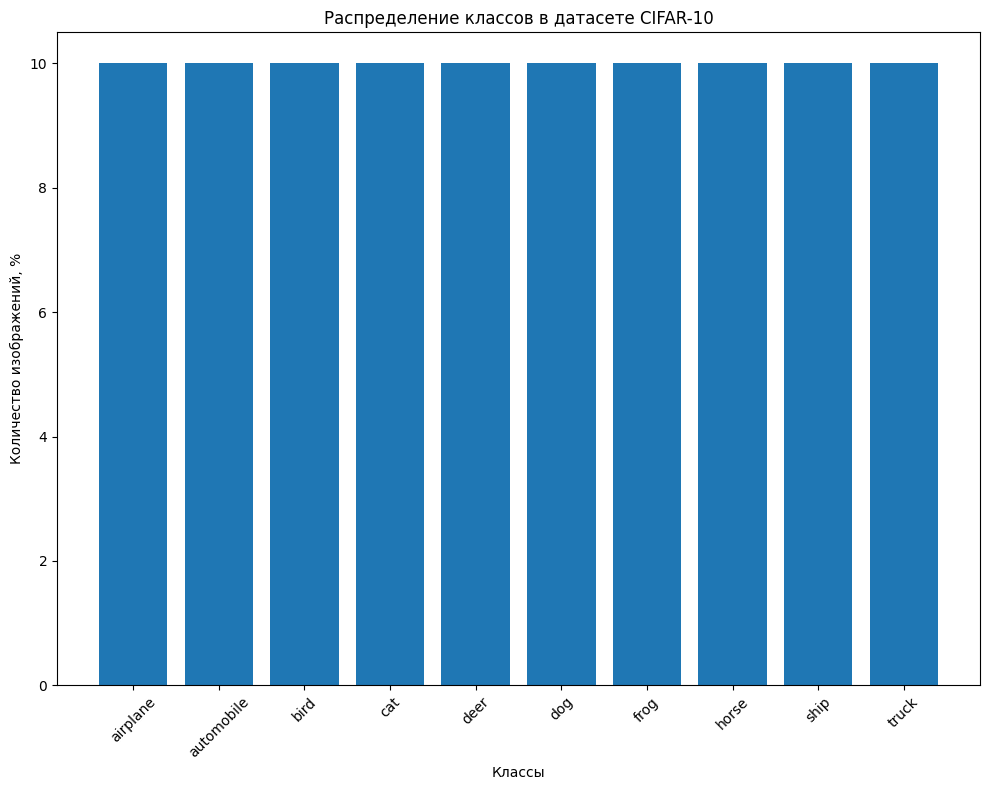

In [4]:
# Будем превращать картинку в torch.Tensor
transform = transforms.ToTensor()

# Загрузим датасеты для train и test
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Получим метки классов
class_labels = train_dataset.classes
class_counts = np.array([0] * len(class_labels))

# Посчитаем число меток классов
for _, label in train_dataset:
    class_counts[label] += 1

class_counts = class_counts / class_counts.sum() * 100

# Построим диаграмму
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_counts)
plt.xlabel('Классы')
plt.ylabel('Количество изображений, %')
plt.title('Распределение классов в датасете CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

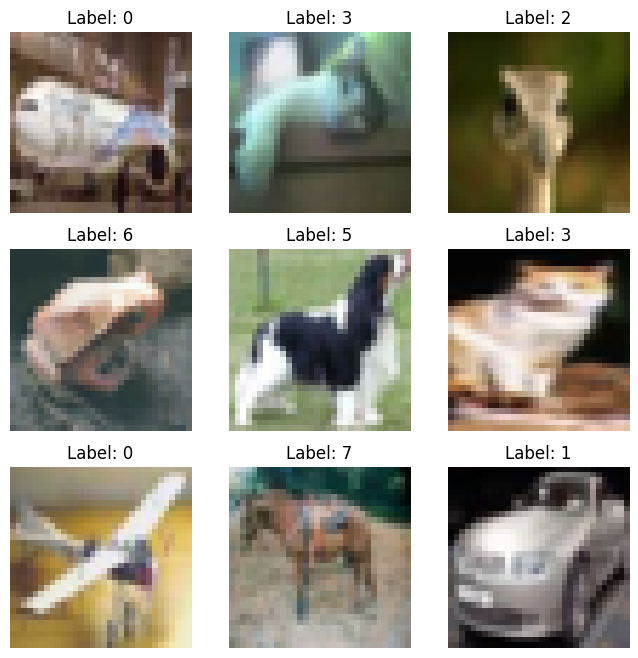

In [5]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

# Создайте сетку 3x3 для отображения изображений
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))  # Перевести изображение из формата (C, H, W) в (H, W, C)
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

Сделайте вывод о сбалансированности датасета:
\
Исходя из этого, какие метрики будем применять для оценки качества модели?

Напишем функции train и test

In [6]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.train()
    model = model.to(device)
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100, desc='Train epoch {}/{}'.format(epoch + 1, epochs))
        for batch_idx, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            # Занулите градиенты оптимизатора
            optimizer.zero_grad()
            # Прямой проход
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Сделайте обратный проход
            loss.backward()
            # Сделайте шаг оптимизации
            optimizer.step()

            running_loss += loss.item()

            # Вычислите точность предсказания
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': '{:.4f}'.format(running_loss / (batch_idx + 1)), 'accuracy': '{:.4f}'.format(correct / total)})

        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(correct / total)
        correct = 0
        total = 0
        test_loss = 0.0
        pbar = tqdm(enumerate(val_loader), total=len(val_loader), ncols=100, desc='Val {}/{}'.format(epoch + 1, epochs))
        with torch.no_grad():
            for batch_idx, (inputs, labels) in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pbar.set_postfix({'loss': '{:.4f}'.format(test_loss / (batch_idx + 1)), 'accuracy': '{:.4f}'.format(correct / total)})
        val_loss_history.append(test_loss / len(val_loader))
        val_acc_history.append(correct / total)

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = test_loss / len(test_loader)

    return accuracy, average_loss

Сделайте разделение на train и val
\
Зачем так делать?

In [7]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = train_test_split(train_dataset, test_size=val_size, random_state=42, shuffle=True)

Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

In [ ]:
# Гиперпараметры
learning_rate = 0.001  # Выберите подходящую величину learning_rate
num_epochs = 10  # Выберите количество эпох
batch_size = 64  # Выберите размер батча

model = Baseline(num_classes=60)

print('Model params: ', count_parameters(model))

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model params:  275100


Обучите модель и постройте графики обучения

In [ ]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=num_epochs)

Val 10/10: 100%|███████████████████| 157/157 [00:00<00:00, 275.65it/s, loss=0.9218, accuracy=0.6821]


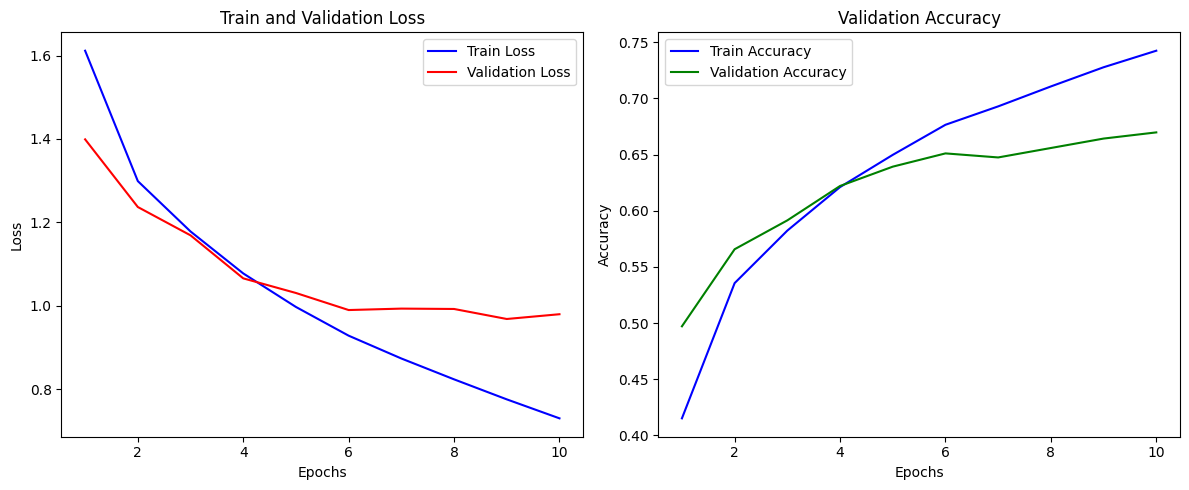

In [ ]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Сделайте выводы о качестве обучения

Оцените тестовую метрику на тестовых данных

In [ ]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.9911
Test Accuracy: 0.6666


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов

In [ ]:
import threading
import time
from threading import Thread

In [ ]:
def FindBest(learning_rate, num_epochs, batch_size, indexes, scores, index):
  model = Baseline(num_classes=10)

  print('Model params: ', count_parameters(model))

  # Определяем функцию потерь и оптимизатор
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=num_epochs)
  test_acc, test_loss = test(model, test_loader, criterion, device)
  indexes.append(index)
  scores.append(test_acc)
  print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))
  return


scores=[]
indexes=[]
# Гиперпараметры
learning_rate = 0.01  # Выберите подходящую величину learning_rate
num_epochs = 10  # Выберите количество эпох
batch_size = 64  # Выберите размер батча
FindBest(learning_rate, num_epochs, batch_size, indexes, scores, 0)
t1 = Thread(target=FindBest, args=(learning_rate, num_epochs, batch_size, indexes, scores, 0))

# Гиперпараметры
learning_rate = 0.01  # Выберите подходящую величину learning_rate
num_epochs = 12  # Выберите количество эпох
batch_size = 64  # Выберите размер батча
t2 = Thread(target=FindBest, args=(learning_rate, num_epochs, batch_size, indexes, scores, 1))

# Гиперпараметры
learning_rate = 0.01  # Выберите подходящую величину learning_rate
num_epochs = 14  # Выберите количество эпох
batch_size = 64  # Выберите размер батча
t3 = Thread(target=FindBest, args=(learning_rate, num_epochs, batch_size, indexes, scores, 2))

# Гиперпараметры
learning_rate = 0.01  # Выберите подходящую величину learning_rate
num_epochs = 16  # Выберите количество эпох
batch_size = 64  # Выберите размер батча
t4 = Thread(target=FindBest, args=(learning_rate, num_epochs, batch_size, indexes, scores, 3))


t1.start()
time.sleep(5)
t2.start()
time.sleep(5)
t3.start()
time.sleep(5)
t4.start()
t1.join()
t2.join()
t3.join()
t4.join()

bestscore = 0
bestindex = 0
index = 0
for score in scores:
    if score > bestscore:
        bestscore = score
        bestindex = index
    index = index + 1


Model params:  268650


Val 10/10: 100%|███████████████████| 157/157 [00:00<00:00, 261.98it/s, loss=1.2723, accuracy=0.5656]


Test Loss: 1.2897
Test Accuracy: 0.5519
Model params:  268650


Train epoch 2/10:   8%|▉            | 48/625 [00:00<00:03, 151.25it/s, loss=1.4377, accuracy=0.4862]

Model params:  268650



Train epoch 2/10:  71%|█████████▏   | 444/625 [00:05<00:02, 81.41it/s, loss=1.4367, accuracy=0.4887]

Model params:  268650



Train epoch 1/12:  58%|███████▌     | 364/625 [00:05<00:03, 79.13it/s, loss=2.0068, accuracy=0.2633]

Train epoch 1/12:  58%|███████▌     | 364/625 [00:05<00:03, 79.13it/s, loss=2.0055, accuracy=0.2641]

Train epoch 2/10:  72%|█████████▍   | 453/625 [00:05<00:02, 75.47it/s, loss=1.4370, accuracy=0.4885]

Train epoch 2/10:  72%|█████████▍   | 453/625 [00:05<00:02, 75.47it/s, loss=1.4372, accuracy=0.4885]

Train epoch 1/12:  60%|███████▊     | 373/625 [00:05<00:03, 69.58it/s, loss=2.0067, accuracy=0.2640]

Train epoch 1/14:   0%|                       | 0/625 [00:00<?, ?it/s, loss=2.7800, accuracy=0.1094]

Train epoch 2/10:  72%|█████████▍   | 453/625 [00:05<00:02, 75.47it/s, loss=1.4373, accuracy=0.4885]

Train epoch 2/10:  72%|█████████▍   | 453/625 [00:05<00:02, 75.47it/s, loss=1.4376, accuracy=0.4885]

Train epoch 2/10:  72%|█████████▍   | 453/625 [00:05<00:02, 75.47it/s, loss=1.4381, accuracy=0.4883]

Train epoch 2/10:  72%|█████████▍   | 453/625 [00:05<00:02, 75.47it/s, loss=1.438

Model params:  268650


Выходные данные были обрезаны до нескольких последних строк (5000).
Train epoch 9/12:  12%|█▋            | 78/625 [00:02<00:15, 35.26it/s, loss=1.3778, accuracy=0.5067]


Train epoch 10/10:  38%|████▌       | 235/625 [00:08<00:11, 35.17it/s, loss=1.0956, accuracy=0.6097]

Train epoch 9/12:  12%|█▋            | 78/625 [00:02<00:15, 35.26it/s, loss=1.3756, accuracy=0.5076]


Train epoch 9/12:  12%|█▋            | 78/625 [00:02<00:15, 35.26it/s, loss=1.3761, accuracy=0.5073]


Train epoch 8/16:  15%|██▏           | 96/625 [00:03<00:14, 35.48it/s, loss=1.1728, accuracy=0.5769]

Train epoch 9/12:  13%|█▊            | 82/625 [00:02<00:15, 35.79it/s, loss=1.3762, accuracy=0.5074]

Train epoch 10/10:  38%|████▌       | 239/625 [00:08<00:10, 35.77it/s, loss=1.0977, accuracy=0.6090]


Train epoch 8/16:  15%|██▏           | 96/625 [00:03<00:14, 35.48it/s, loss=1.1719, accuracy=0.5772]


Train epoch 8/16:  16%|██           | 100/625 [00:03<00:14, 35.84it/s, loss=1.1719, accuracy=0.5772]

Train epo

Test Loss: 1.4250
Test Accuracy: 0.5201


Выходные данные были обрезаны до нескольких последних строк (5000).

Train epoch 11/12:  49%|█████▊      | 304/625 [00:07<00:07, 41.82it/s, loss=1.3458, accuracy=0.5165]

Train epoch 11/12:  49%|█████▉      | 309/625 [00:08<00:35,  8.95it/s, loss=1.3466, accuracy=0.5166]

Train epoch 10/16:  56%|██████▋     | 350/625 [00:10<00:21, 12.88it/s, loss=1.1736, accuracy=0.5785]

Train epoch 10/16:  56%|██████▋     | 350/625 [00:10<00:21, 12.88it/s, loss=1.1733, accuracy=0.5785]

Train epoch 10/14:  83%|█████████▉  | 516/625 [00:15<00:15,  6.99it/s, loss=2.3038, accuracy=0.0979]

Train epoch 11/12:  49%|█████▉      | 309/625 [00:10<00:35,  8.95it/s, loss=1.3455, accuracy=0.5169]

Train epoch 10/16:  57%|██████▊     | 354/625 [00:11<00:43,  6.20it/s, loss=1.1731, accuracy=0.5787]

Train epoch 10/14:  83%|█████████▉  | 516/625 [00:16<00:15,  6.99it/s, loss=2.3039, accuracy=0.0978]

Train epoch 10/14:  83%|█████████▉  | 520/625 [00:16<00:20,  5.10it/s, loss=2.3039, accuracy=0.0978]

Train epoch 1

Test Loss: 1.4503
Test Accuracy: 0.4725


Train epoch 12/16:  55%|██████▌     | 345/625 [00:16<00:05, 53.65it/s, loss=1.1289, accuracy=0.5988]

Train epoch 12/16:  55%|██████▌     | 345/625 [00:16<00:05, 53.65it/s, loss=1.1288, accuracy=0.5989]

Train epoch 12/16:  55%|██████▌     | 345/625 [00:16<00:05, 53.65it/s, loss=1.1286, accuracy=0.5991]

Train epoch 12/14:  75%|████████▉   | 466/625 [00:20<00:03, 47.76it/s, loss=2.3033, accuracy=0.1006]

Train epoch 12/16:  56%|██████▋     | 351/625 [00:16<00:04, 55.13it/s, loss=1.1282, accuracy=0.5989]

Train epoch 12/16:  56%|██████▋     | 351/625 [00:16<00:04, 55.13it/s, loss=1.1277, accuracy=0.5992]

Train epoch 12/16:  56%|██████▋     | 351/625 [00:16<00:04, 55.13it/s, loss=1.1284, accuracy=0.5989]

Train epoch 12/16:  56%|██████▋     | 351/625 [00:16<00:04, 55.13it/s, loss=1.1284, accuracy=0.5990]

Train epoch 12/16:  56%|██████▋     | 351/625 [00:16<00:04, 55.13it/s, loss=1.1286, accuracy=0.5989]

Train epoch 12/16:  56%|██████▋     | 351/625 [00:16<00:04, 55.13it/s, loss=1.1289

Test Loss: 2.3029
Test Accuracy: 0.1000


Val 16/16: 100%|███████████████████| 157/157 [00:00<00:00, 292.60it/s, loss=1.5137, accuracy=0.5171]


Test Loss: 1.5029
Test Accuracy: 0.5049


In [ ]:
print(bestscore)

0.5519


In [43]:
  learning_rate = 0.0009  # Выберите подходящую величину learning_ratE
  num_epochs = 20  # Выберите количество эпох
  batch_size = 64  # Выберите размер батча
  model = ImprovedModel(num_classes=20)

  print('Model params: ', count_parameters(model))

  # Определяем функцию потерь и оптимизатор
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  train_loss_history, train_acc_history, vaёёl_loss_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=num_epochs)
  test_acc, test_loss = test(model, test_loader, criterion, device)
  print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Model params:  10408468


Val 20/20: 100%|███████████████████| 157/157 [00:01<00:00, 125.05it/s, loss=1.0532, accuracy=0.7948]


Test Loss: 0.8207
Test Accuracy: 0.8249
